### This notebook compares the regrets calculated using the likelihood (our approach) vs. the value function (original Environment Design paper approach)

In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.inference.sampling import get_parameter_sample
from src.utils.make_environment import transition_matrix, get_candidate_environments
from src.utils.environment_design import environment_search
from src.utils.visualization import plot_posterior_distribution

np.set_printoptions(linewidth=160, precision=2)

In [3]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 6, 6 #(width, height of environment)
n_states, n_actions = N * M, 4

# Create a type of BigSmall world
R_true = np.zeros((N, M))
R_true[5, 5] = 1
R_true[1, 5] = 1
R_true = R_true.flatten()

goal_states = np.where(R_true != 0)[0]
del R_true


#Sample possible rewards, in this case we set the ranges for gamma and p to 0 as we are not learning them
posterior_samples = get_parameter_sample(n_samples=n_posterior_samples, 
                                         N=N,
                                         M=M, 
                                         ranges=[[0.8, 0.8], [0.9, 0.9], [1, 10]])

Update Rewards, create richer reward landscape


### Visualize Reward Samples

The expert is very certain that there are negative rewards in the middle and believes there could be high rewards in the bottom right or the middle right

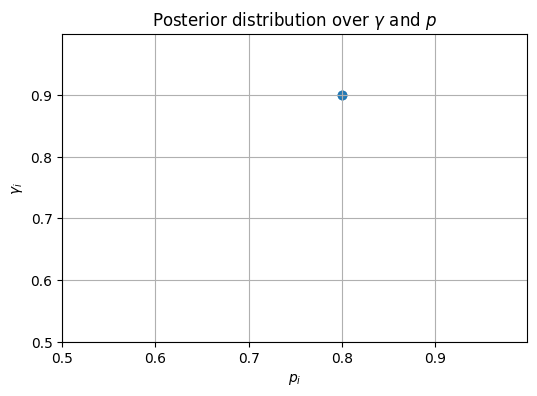

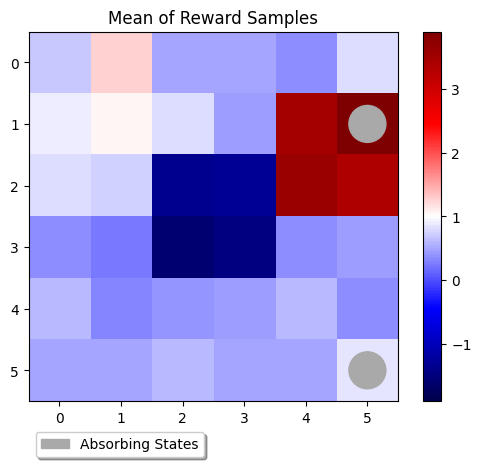

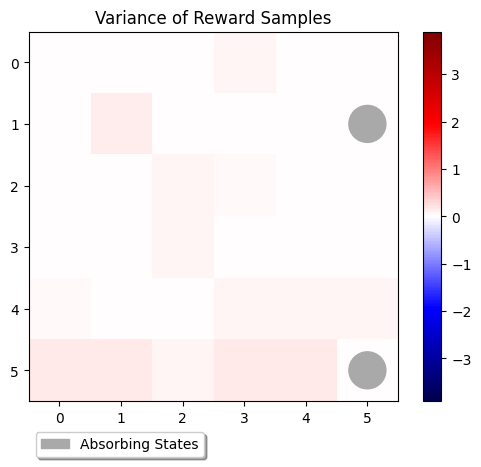

In [4]:
plot_posterior_distribution(posterior_samples=posterior_samples,
                            N=N,
                            M=M,
                            absorbing_states=goal_states)

Generate candidate environments and calculate regret for candidate environments using likelihood and value function

In [5]:
#Generate true transition matrix
T_true = transition_matrix(N, M, p=0.9, absorbing_states=goal_states)


#Generate candidate environments. These are the environments for which we are going to calculate the regret
candidate_envs_value = get_candidate_environments(
    n_env_samples, N, M, T_true, goal_states, randomize_start_state=False
)
#use same environments for Bayesian Regret using likelihood as for Bayesian Regret using value function
candidate_envs_likelihood = deepcopy(candidate_envs_value)


envs_value = environment_search(
    N,
    M,
    "value",
    goal_states,
    posterior_samples,
    n_traj_per_sample,
    candidate_envs_value,
    return_sorted=False
)
envs_likelihood = environment_search(
    N,
    M,
    "likelihood",
    goal_states,
    posterior_samples,
    n_traj_per_sample,
    candidate_envs_likelihood,
    return_sorted=False
)

Evaluating candidate environments using value:  13%|█▎        | 2/15 [00:00<00:05,  2.21it/s, highest_regret=0.839]

Evaluating candidate environments using value: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s, highest_regret=0.844]
Evaluating candidate environments using likelihood: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s, highest_regret=0.466]


In [6]:
regrets_value_raw = [envs_value[id].regret for id in range(len(envs_value))]
regrets_likelihood_raw = [envs_likelihood[id].regret for id in range(len(envs_likelihood))]

# regrets_value_raw_zero_mean = regrets_value_raw - np.mean(regrets_value_raw)
# regrets_likelihood_raw_zero_mean = regrets_likelihood_raw - np.mean(regrets_likelihood_raw)

var_value = np.var(regrets_value_raw)
var_likelihood = np.var(regrets_likelihood_raw)
print(f"Variance of Regrets using value function: {var_value}")
print(f"Variance of Regrets using likelihood function: {var_likelihood}")
print(f"Ratio of regret variances (>1 means value is higher): {var_value/var_likelihood}")

corr = np.corrcoef(regrets_value_raw, regrets_likelihood_raw)
print("Correlation of regrets calculated ", corr)

# normalize to zero mean and standard variance
regrets_value = (regrets_value_raw - np.mean(regrets_value_raw)) / np.std(
    regrets_value_raw
)
regrets_likelihood = (
    regrets_likelihood_raw - np.mean(regrets_likelihood_raw)
) / np.std(regrets_likelihood_raw)

Variance of Regrets using value function: 0.05812666145252843
Variance of Regrets using likelihood function: 0.027106657361906976
Ratio of regret variances (>1 means value is higher): 2.1443684728982446
Correlation of regrets calculated  [[1.   0.46]
 [0.46 1.  ]]


In [7]:
indexes_value = np.argsort(regrets_value)
indexes_likelihood = np.argsort(regrets_likelihood)
print(np.flip(indexes_value))
print(np.flip(indexes_likelihood))

[12  1  2  8  5  3 13  0 11  9 14 10  6  4  7]
[13  8 11  5 10  6  0 14  3  9  2  1  4 12  7]


In [8]:
top_n = 5

top_3_value = indexes_value[-top_n:]
top_3_likelihood = indexes_likelihood[-top_n:]
bottom_3_value = indexes_value[:top_n]
bottom_3_likelihood = indexes_likelihood[:top_n]

print(f"Top {top_n} Regret Environments Value: ", top_3_value)
print(f"Top {top_n} Regret Environments Likelihood: ", top_3_likelihood)
print(f"Bottom {top_n} Regret Environments Value: ", bottom_3_value)
print(f"Bottom {top_n} Regret Environments Likelihood: ", bottom_3_likelihood)

Top 5 Regret Environments Value:  [ 5  8  2  1 12]
Top 5 Regret Environments Likelihood:  [10  5 11  8 13]
Bottom 5 Regret Environments Value:  [ 7  4  6 10 14]
Bottom 5 Regret Environments Likelihood:  [ 7 12  4  1  2]


Text(0.5, 1.0, 'Regret calculated using the Value Function \nand the Likelihood across 25 randomly generated environments')

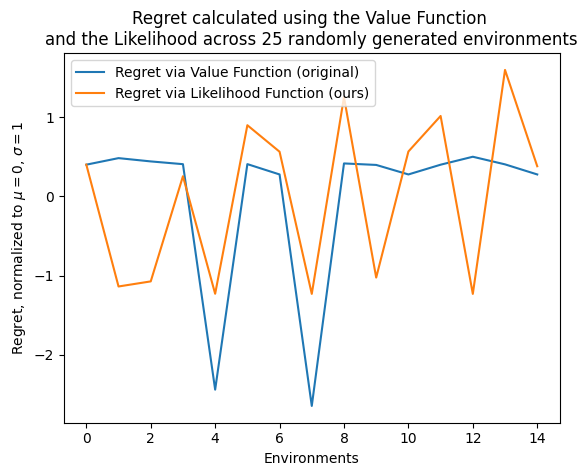

In [9]:
import matplotlib.pyplot as plt

plt.plot(regrets_value, label="Regret via Value Function (original)")
plt.plot(regrets_likelihood, label="Regret via Likelihood Function (ours)")
plt.legend()
plt.xlabel("Environments")
plt.ylabel("Regret, normalized to $\mu = 0$, $\sigma = 1$")
plt.title(
    "Regret calculated using the Value Function \nand the Likelihood across 25 randomly generated environments"
)